In [45]:
import pandas as pd
import numpy as np
import arviz as az
import pylab as plt
from tqdm import tqdm
import random
import statsmodels.api as sm

from pymc3 import *

from scipy.stats import norm, ttest_ind

RANDOM_SEED = 58

In [2]:
def inv_log_odds(LO):
    return 1/(1+ (np.exp(-LO)))

In [27]:
basic_linear_data = pd.DataFrame(np.random.uniform(low=-1, high=1, size=(10000,1)),
                         columns=list("V."+pd.Series(list(range(1,2))).apply(str))
                        )
basic_linear_data["V.0"] = 1
predictor_columns = list("V."+pd.Series(list(range(0,2))).apply(str))
basic_linear_data = basic_linear_data[predictor_columns]
lm_true_beta = np.array([-.5,-.4])#,-.3])#,-.2,-.1,.1,.2,.3,.4,.5,0.6])

basic_linear_data["Y0_given_X"] = (
    np.matmul(basic_linear_data.to_numpy(), lm_true_beta) + 
    np.random.normal(loc=0, scale=.5, size=basic_linear_data.shape[0])
)

basic_linear_data["Y1_given_X"]  = (
    basic_linear_data["Y0_given_X"] + 
    np.random.normal(loc=.3, scale=.3, size = basic_linear_data.shape[0])
)

basic_linear_data["Tau"] = basic_linear_data["Y1_given_X"]-basic_linear_data["Y0_given_X"]

log_odds = np.matmul(basic_linear_data[predictor_columns].to_numpy(), lm_true_beta)
basic_linear_data["P(T=1)"] = inv_log_odds(log_odds)
basic_linear_data["T"] = np.random.binomial(n=1, p=basic_linear_data["P(T=1)"])

In [28]:
basic_linear_data["P(T=1)"]

0       0.300611
1       0.395737
2       0.407408
3       0.449710
4       0.329872
          ...   
9995    0.429909
9996    0.429864
9997    0.377427
9998    0.468089
9999    0.374173
Name: P(T=1), Length: 10000, dtype: float64

In [29]:
predictor_columns
print(basic_linear_data["T"].sum()/len(basic_linear_data["T"]))
print(basic_linear_data["Y1_given_X"].mean())
print(basic_linear_data["Y0_given_X"].mean())

0.3791
-0.20008366299578373
-0.5014854568617522


Ttest_indResult(statistic=36.44560635605202, pvalue=1.2473109762084484e-281)

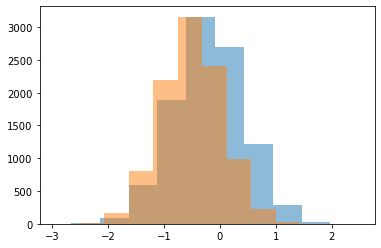

In [30]:
_=plt.hist(basic_linear_data["Y1_given_X"], alpha=.5)
_=plt.hist(basic_linear_data["Y0_given_X"], alpha=.5)
ttest_ind(
    basic_linear_data["Y1_given_X"], 
    basic_linear_data["Y0_given_X"], 
)

In [31]:
dat = basic_linear_data#pd.read_csv("data/balanced_caus_sim_1_N=10000_P=1000_noise_percent=0.64_set_1.csv")
print(dat.shape)
print(dat['T'].sum())
dat['V.0'] = 1
dat.head()

(10000, 7)
3791


,V.0,V.1,Y0_given_X,Y1_given_X,Tau,P(T=1),T
0,1,0.860970,-0.789889,-0.380631,0.409258,0.300611,0
1,1,-0.191850,-0.291764,-0.293839,-0.002075,0.395737,1
2,1,-0.313272,-0.919698,-0.620202,0.299497,0.407408,1
3,1,-0.745390,-0.081769,0.385723,0.467492,0.449710,0
4,1,0.521909,-0.334349,0.129310,0.463659,0.329872,0


In [32]:
data_stats = pd.DataFrame(
    {
        "mean" : dat.mean(axis = 0),
        "std" : dat.std(axis = 0)
    }
)
data_stats.T

,V.0,V.1,Y0_given_X,Y1_given_X,Tau,P(T=1),T
mean,1.0,-0.004293,-0.501485,-0.200084,0.301402,0.379454,0.379100
std,0.0,0.576764,0.543937,0.622934,0.301200,0.053869,0.485187


In [33]:
predictors = ["V.0","V.1"]#,"V.2"]#,"V.3","V.4","V.5","V.6","V.7","V.8","V.9","V.10"]
X=dat[predictors]
T=np.array(dat['T'])
sum(T)/len(T)

0.3791

In [34]:
prior_means = 0#np.array([-.5,-.4,-.3,-.2,-.1,.1,.2,.3,.4,.5,0.6])#np.zeros(len(predictors))

with Model() as propensity_score_model:
    Beta = Normal('Beta', mu=prior_means, sigma=3, shape=len(predictors))
    error = HalfNormal('sig', sigma=5)
    model_log_odds = math.dot(X, Beta)
    y = Bernoulli('y', p=inv_log_odds(model_log_odds), observed=T)

with propensity_score_model:
    start = find_MAP()
    propensity_score_trace = sample(1000, tune=1000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, Beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/omarchavez/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5bfb028e0>,
      dtype=object)

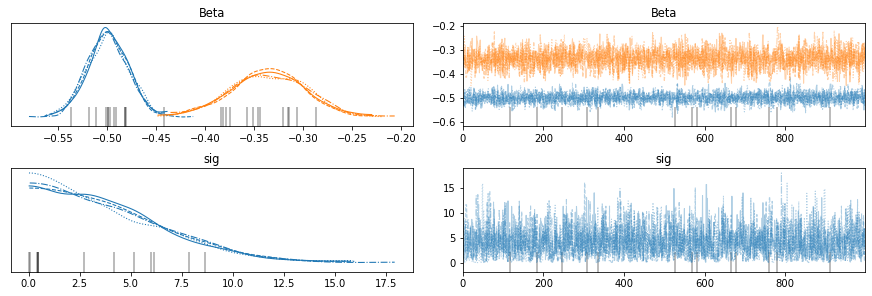

In [35]:
traceplot(propensity_score_trace)

In [36]:
posterir_log_odds = np.matmul(X.to_numpy(), propensity_score_trace["Beta"].T)
#posterior_odds = np.exp(posterir_log_odds)

In [37]:
posterior_probs = inv_log_odds(posterir_log_odds)
posterior_mean_probs = posterior_probs.mean(axis=1)
np.mean(posterior_probs)

0.37918551459640437

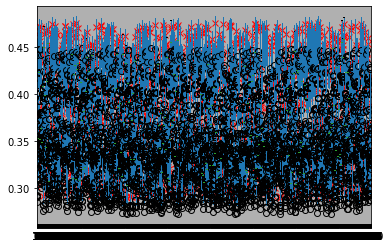

In [48]:
# How well did we fit the true probability of Treatment assignment
sub_N = 2000
posterior_prob_of_T = pd.DataFrame(posterior_probs.T)
basic_linear_data.loc[:sub_N, ['P(T=1)']]
plt.plot(range(1,sub_N+2),basic_linear_data.loc[:sub_N, ['P(T=1)']], 'x', color='red')
(posterior_prob_of_T.loc[:500,:sub_N]).boxplot()

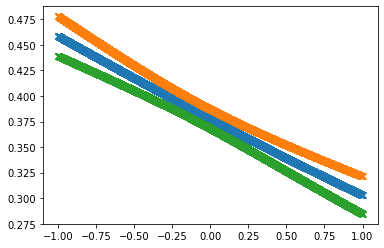

In [46]:
p_hat=posterior_prob_of_T.loc[:500,:].mean(axis=0)
p_plus = p_hat+posterior_prob_of_T.loc[:500,:].std(axis=0)*2
p_minus = p_hat-posterior_prob_of_T.loc[:500,:].std(axis=0)*2

plt.plot(X.loc[:,"V.1"],p_hat, 'x')
plt.plot(X.loc[:,"V.1"],p_plus, 'x')
plt.plot(X.loc[:,"V.1"],p_minus, 'x')

In [47]:
log_reg = sm.Logit(T, X).fit() 
log_reg.summary()


Optimization terminated successfully.
         Current function value: 0.659253
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Thu, 01 Oct 2020   Pseudo R-squ.:                0.006583
Time:                        09:29:00   Log-Likelihood:                -6592.5
converged:                       True   LL-Null:                       -6636.2
Covariance Type:            nonrobust   LLR p-value:                 8.967e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V.0           -0.4993      0.021    -24.085      0.000      -0.540      -0.459
V.1           -0.3356      0.036     -9.306      0.000      -0.406      -0.265
==============================================================================
"""

### sample row from trace['Beta'] and compute log_odds.  repeat to form distribution of log_odds
### compute column means to get compute E(log_odds).  Use outputs to perform Y_i* evaluation.

In [33]:
Y_obs = np.array(dat['Y0_given_X'])
Y_obs[dat['T'] == 1] = dat.loc[dat['T'] == 1,'Y1_given_X']

In [34]:
def get_Y_i_star(Y_obs, p):
    return Y_obs * (dat['T'] - p)/(p*(1-p))

In [36]:
Y_i_star_sp = get_Y_i_star(Y_obs, posterior_mean_probs)
#Mean Estimate - Single Propensity Score plug in
with Model() as sp_CATE_model:
    Beta = Normal('Beta', mu=0, sigma=10, shape=len(predictors))
    Tau_estimate_mu = math.dot(X, Beta)
    sig = HalfNormal('sig', sigma=5)
    Tau_estimate = Normal("Tau_estimate", mu=Tau_estimate_mu, sigma=sig, observed=Y_i_star_sp)


with sp_CATE_model:
    start = find_MAP()
    sp_CATE_score_trace = sample(1000, tune=1000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, Beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


/Users/omarchavez/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faac6e45ac0>,
      dtype=object)

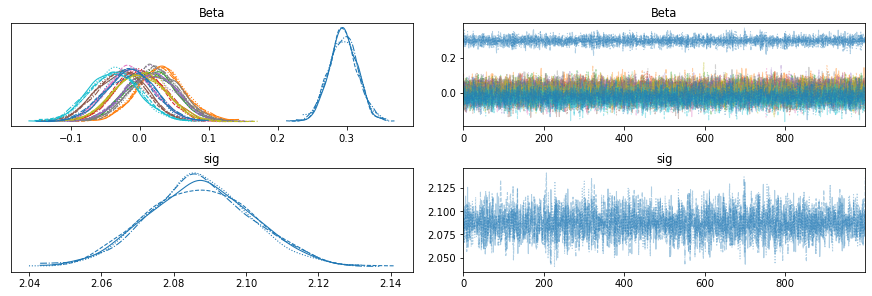

In [37]:
traceplot(sp_CATE_score_trace)

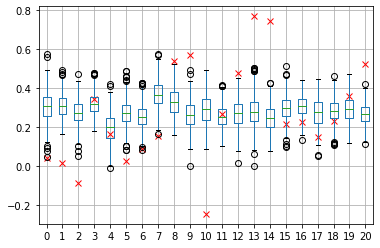

In [38]:
sub_N = 20
posterior_sp_Tau = np.matmul(X.to_numpy(), sp_CATE_score_trace["Beta"].T)
sp_Tau = pd.DataFrame(posterior_sp_Tau.T)

plt.plot(range(1,sub_N+2),dat.loc[:sub_N, 'Tau'], 'x', color='red')
sp_Tau.loc[:500,:sub_N].boxplot()

### Propagate Uncertainty of Propensity Scores by sampling from propensity score posterior and running a single iteration of CATE model after burn in and construct a "super-posterior"

In [41]:
posterior_probs.shape

(10000, 4000)

In [128]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

col_index = random.sample(range(posterior_probs.shape[1]),100)
for j in tqdm(range(len(col_index))):
    Y_i_star_p_j = get_Y_i_star(Y_obs, posterior_probs[:,col_index[j]])
    #Mean Estimate - Single Propensity Score plug in
    with Model() as post_p_CATE_model:
        Beta = Normal('Beta', mu=0, sigma=10, shape=len(predictors))
        Tau_estimate_mu =  math.dot(X, Beta)
        sig = HalfNormal('sig', sigma=5)
        Tau_estimate = Normal("Tau_estimate", mu=Tau_estimate_mu, sigma=sig, observed=Y_i_star_p_j)
    
    
    with post_p_CATE_model:
        start = find_MAP(progressbar=False)
        post_p_CATE_trace = sample(100, tune=1000, start=start, progressbar=False)
    
    if j==0:
        all_runs_CATE_trace = pd.DataFrame(post_p_CATE_trace['Beta'])
    else: 
        all_runs_CATE_trace = pd.concat([all_runs_CATE_trace, pd.DataFrame(post_p_CATE_trace['Beta'])])

100%|██████████| 100/100 [25:35<00:00, 15.35s/it]


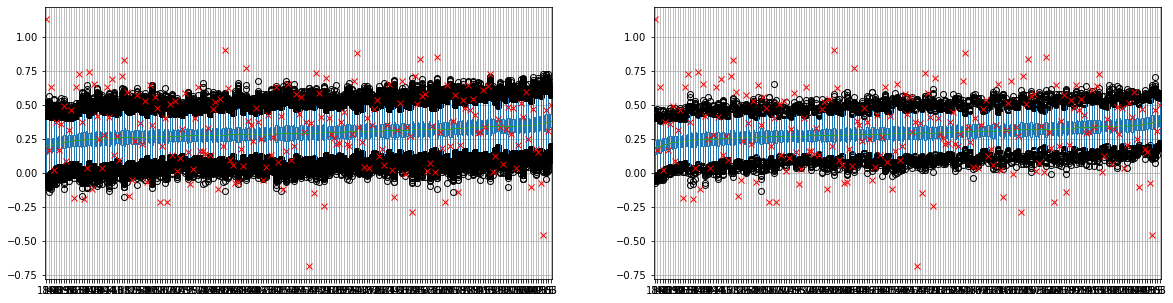

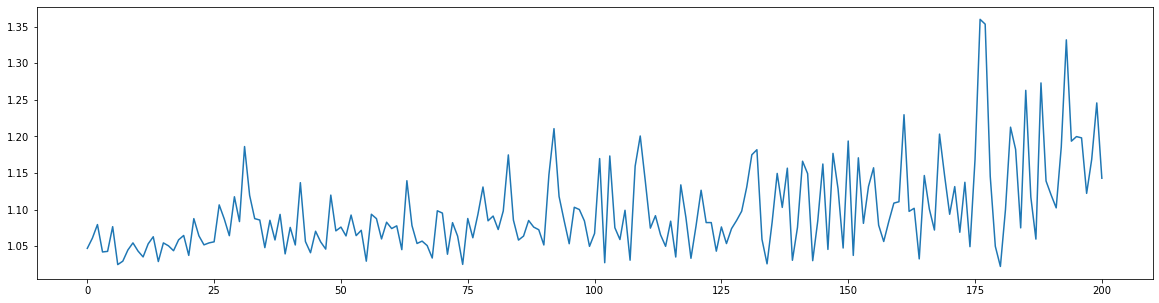

In [129]:
sub_N = 200
posterir_fp_Tau = np.matmul(X.to_numpy(), all_runs_CATE_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
temp_fp = fp_Tau.loc[:, :sub_N]
temp2 = temp_fp.reindex(temp_fp.mean().sort_values().index, axis=1)
_=temp2.boxplot()
temp_Tau = dat.loc[:sub_N, 'Tau']
plt.plot(range(1,sub_N+2),temp_Tau[temp2.columns], 'x', color='red')

plt.subplot(1, 2, 2)
temp_sp = sp_Tau.loc[:, :sub_N]
temp3 = temp_sp.reindex(temp_fp.mean().sort_values().index, axis=1)
_=temp3.boxplot()
plt.plot(range(1,sub_N+2),temp_Tau[temp2.columns], 'x', color='red')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(range(len(temp2.std(axis=0)[:sub_N+1])),temp2.std(axis=0)[:sub_N+1]/temp3.std(axis=0))

In [133]:
#Coverage
#Tau > max
fp_max_violation = fp_Tau.max(axis=0) < dat.loc[:, 'Tau']
fp_min_violation = fp_Tau.min(axis=0) > dat.loc[:, 'Tau']
coverage_fp = 1-(sum(fp_max_violation)+sum(fp_min_violation))/len(fp_min_violation)
print("Coverage:",coverage_fp)

Coverage: 0.6955


In [134]:
sp_max_violation = sp_Tau.max(axis=0) < dat.loc[:, 'Tau']
sp_min_violation = sp_Tau.min(axis=0) > dat.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
print("Coverage:",coverage_sp)

Coverage: 0.5775


In [135]:
(coverage_fp-coverage_sp)/coverage_sp

0.2043290043290043

### Next we can consider the effect on matching and failutre to incorporate the uncertainty in the propensity score.

In [154]:
print(pd.DataFrame(posterior_probs).shape)
print(pd.DataFrame(posterior_mean_probs).shape)

(10000, 4000)
(10000, 1)


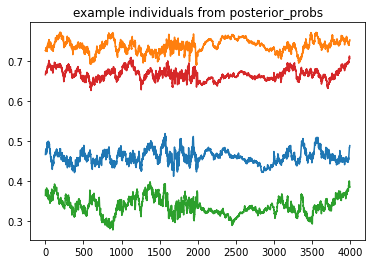

In [169]:
plt.plot(posterior_probs[0,:])
plt.plot(posterior_probs[4,:])
plt.plot(posterior_probs[5000,:])
plt.plot(posterior_probs[9999,:])
_=plt.title("example individuals from posterior_probs")

In [179]:
def match_on_propensity_score(Y_obs, TorC, prop_score):
    
    y_treat=np.array(Y_obs[TorC==1])
    y_control=np.array(Y_obs[TorC==0])

    ps_treat=np.array(prop_score[TorC==1])
    ps_control=np.array(prop_score[TorC==0])
    
    diffs = np.zeros(len(ps_treat))
    for i in range(len(ps_treat)):
        
        absolute_p_diff = np.absolute(ps_treat[i] - ps_control)
        min_index = np.where(absolute_p_diff == np.amin(absolute_p_diff))
        diffs[i] = y_treat[i] - y_control[min_index]
        
    return diffs

import time

In [180]:
st = time.time()
treatment_effect_sps_diffs = match_on_propensity_score(
    Y_obs=Y_obs, 
    TorC=dat['T'], 
    prop_score=posterior_mean_probs)
print(time.time() - st)

0.10498189926147461


std: 0.784482707253388 std error: 0.012608742891663983
mean: 0.29112732192297514


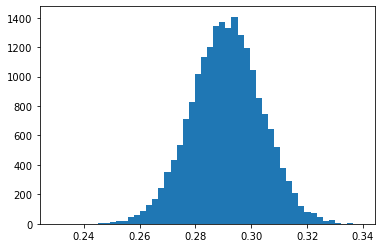

In [227]:
sampled_sp_diffs_mean = np.random.normal(
    loc=np.mean(treatment_effect_sps_diffs),
    scale=np.std(treatment_effect_sps_diffs)/np.sqrt(len(treatment_effect_sps_diffs)),
    size=20000
)
_=plt.hist(sampled_sp_diffs_mean, 50)
print("std:", np.std(treatment_effect_sps_diffs), 
      "std error:", np.std(treatment_effect_sps_diffs)/np.sqrt(len(treatment_effect_sps_diffs)))
print("mean:", np.mean(treatment_effect_sps_diffs))


In [214]:
treatment_effect_fps_diffs = np.zeros((sum(dat['T']), posterior_probs.shape[1]))
for j in tqdm(range(posterior_probs.shape[1])):
    treatment_effect_fps_diffs[:,j] = match_on_propensity_score(
        Y_obs=Y_obs, 
        TorC=dat['T'], 
        prop_score=posterior_probs[:,j])


100%|██████████| 4000/4000 [05:37<00:00, 11.87it/s]


std error: 0.00982846156882222
mean: 0.2942063501636904


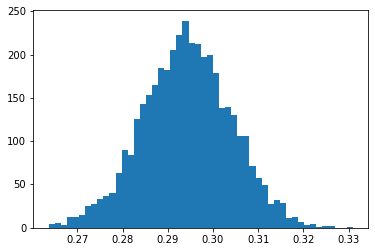

In [225]:
fps_mean_treatment_effects = treatment_effect_fps_diffs.mean(axis=0)
_=plt.hist(fps_mean_treatment_effects,50)
print("std error:", np.std(fps_mean_treatment_effects))
print("mean:", np.mean(fps_mean_treatment_effects))

0.00982846156882222